### Models X3LV | created 09/07/2022 | final model compilation
> This notebook was created as a more lenient version of X3, based on the same model but using less stringent filtering parameters.

##### Imports

In [2]:
# General
import os
import sys
from tqdm import tqdm
import pickle
import random
import string
import multiprocessing
import numpy as np
import pandas as pd
from datetime import date
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

# Random Forest
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)] 
numpy 1.22.3 
pandas 1.4.2 
plotnine 0.8.0 
statsmodels 0.13.2 
sklearn 1.1.1


#### 1) Pre-Processing

In [3]:
def opera_to_df(path, header_length = 9):
    # Import tab separated .txt file
    raw_df = pd.read_csv(path, sep = '\t', skiprows = header_length)
    raw_df = raw_df.dropna(axis = 1, how = 'all')   # Remove empty columns
    return raw_df

def make_cuts_2d(df, columns, arr_values):
    cuts = []   # Output dataframes
    for value in arr_values:
        cut = df[(df[columns[0]] == value[0]) & (df[columns[1]] == value[1])]
        cuts.append(cut)
    return cuts

#### 2) Model I/O

In [4]:
def save_model(model, path, title):
    """ 
    Stores the model with a description in a format that 
    can be read by `load_model`.

    Parameters
    ---
    `model (sklearn model)`
        The model to be saved.

    `path (string)`
        The folder path (which does not exist) to store the model in.

    `title (string)`
        The name of the model.
    
    """
    # Identifier
    date_raw = date.today()
    date_formatted = date_raw.strftime("%d%m%y")

    # Make Folder
    folderpath = os.path.join(path, title).replace("\\", "/")
    os.mkdir(folderpath)

    # Descriptor .txt that gets stored within model folder
    descriptor =    "Given Title: " + str(title) + \
                    str(model.feature_names_in_) + \
                    str(model.feature_importances_) + "\n" + \
                    "Features: " + str(model.n_features_) + "\n" + \
                    "Max Depth: " + str(model.max_depth)

    # Write Descriptor
    with open(folderpath + '/readme.txt', 'w') as f:
        f.write(descriptor)

    # Write Model
    pickle.dump(model, open(folderpath + f'/{title}.rfc', "wb"))


In [5]:
def load_model(path):
    """
    Loads in `(model_title, model)`.

    Parameters
    ---
    `path (string)`
        Folder in which the model is stored.  

    Returns
    ---
    `title (string)`
        Model title.
    `model (sklearn model)`
        Model object. 
    """
    title = os.path.basename(os.path.normpath(path))
    model = pickle.load(open(f'{path}/{title}.rfc', 'rb'))
    return title, model

#### 3) Clustering

In [6]:
def dist(p1, p2):
    sp1, sp2 = np.array(p1[0:3]), np.array(p2[0:3])
    #print(f'SP1: {sp1}, SP2: {sp2}')
    sp_dist = np.linalg.norm(sp1 - sp2)
    
    tp1, tp2 = np.array(p1[3]), np.array(p2[3])
    tp_dist = np.linalg.norm(tp1 - tp2)

    fp1, fp2 = np.array(p1[4]), np.array(p2[4])
    fp_dist = np.linalg.norm(fp1 - fp2)

    return sp_dist, tp_dist, fp_dist

def bunch_by_spot(df, sp_dist, tp_dist):
    """
    Bunches spots directly in the `df` passed in. 
    Adds `cluster_id` and `cluster_size`.
    """
    # 0) Add EMPTY columns
    n_rows = df.shape[0]
    col_empty = [0 for x in range(0, n_rows)]

    df['cluster_id'], df['cluster_size'] = col_empty, col_empty

    at_id = 1   # Denotes the next available cluster id
    
    # 1) Go Across All Points
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        ids_in_range = []   # Store all in same cluster
        current = (row['Position X [µm]'], row['Position Y [µm]'], row['Plane'], row['Timepoint'], row['Field'])

        # 2) Fetch all close to point
        for in_index, in_row in df.iterrows():
            if in_index != index:
                against = (in_row['Position X [µm]'], in_row['Position Y [µm]'], in_row['Plane'], in_row['Timepoint'], row['Field'])
                sp_dist, tp_dist, fp_dist = dist(current, against)

                if sp_dist < 2 and tp_dist < 2 and fp_dist == 0:
                    ids_in_range.append(in_index)

        # 3) Obtain ids_in_range subset that has clusters
        ls_idxs_to_remove = []
        ls_clusters_to_connect = []

        for idx in ids_in_range:
            if df.at[idx, 'cluster_id'] != 0:
                ls_idxs_to_remove.append(idx)
                ls_clusters_to_connect.append(df.at[idx, 'cluster_id'])

        ids_in_range = [x for x in ids_in_range if x not in ls_idxs_to_remove]

        curr_id = at_id

        # 3.1) Replace In Existent Clusters
        df['cluster_id'] = df['cluster_id'].replace(ls_clusters_to_connect, curr_id)

        # 3.2) Add to novel
        for idx in ids_in_range:
            df.at[idx, 'cluster_id'] = curr_id

        at_id += 1      # Advance available cluster id
    
    # 4) Add Cluster Sizes
    df['cluster_size'] = df.groupby('cluster_id')['cluster_id'].transform('count')

In [7]:
def bunch_by_nucleus(df):
    """
    Bunches spot clusters together into nuclei 
    and appends it as `nucleus_id` to the dataframe.

    IDs base value is 0, rows still sporting this after bunching should
    be ignored.
    """
    # 0) Add EMPTY column
    n_rows = df.shape[0]
    col_empty = [0 for x in range(0, n_rows)]

    df['nucleus_id'] = col_empty
    timepoints = df.Timepoint.unique()  # Obtain unique timepoints

    # 1) Do BUNCHING
    glob_nuc_counter = 1

    for timepoint in timepoints:
        reference = []  # List of connections

        df_tp = df[df.Timepoint == timepoint]   # Subdf with only timepoint
        clusters = df_tp.cluster_id.unique()

        for cluster in clusters:
            # FIRST check whether we are dealing with cluster 0
            # this is the 'empty' cluster for spots that could not
            # be clustered and should therefore be ignored.
            if cluster != 0:    
                nps_current = []
                
                df_cluster = df_tp[df_tp.cluster_id == cluster]

                for index, row in df_cluster.iterrows():
                    # Obtain current NP
                    np_row = (row['Plane'], row['coloc AR - Object No in Clustered Nuclei w/o Border Round Selected'], 0)
                    if np_row not in nps_current:
                        nps_current.append(np_row)
                
                terminate = False

                for np_row in nps_current:
                    # Find nucleus
                    for idx, ref in enumerate(reference):
                        # If FOUND
                        if ref[0:2] == np_row[0:2]:
                            # Annotate from reference
                            true_nuc_id = ref[2]
                            nps_annotated = [(x[0], x[1], true_nuc_id) for x in nps_current]
                            ##
                            for np_annotated in nps_annotated:
                                if np_annotated not in reference:
                                    reference.append(np_annotated)
                            # Set all belonging to cluster to this nuc_id
                            df.nucleus_id.mask(df.cluster_id == cluster, true_nuc_id, inplace = True)
                            terminate = True
                    if terminate is True:
                        break

                if terminate is False:
                    # If NOT FOUND
                    nps_annotated = [(x[0], x[1], glob_nuc_counter) for x in nps_current]
                    # Put in references
                    for np_annotated in nps_annotated:
                        reference.append(np_annotated)
                    # Mask out
                    df.nucleus_id.mask(df.cluster_id == cluster, glob_nuc_counter, inplace = True)
                    glob_nuc_counter += 1

In [127]:
def fetch_well_results(df, path_plate_results, threshold):
    # Obtain plate results

    pr = opera_to_df(path_plate_results, header_length=8)
    plate_cut = pr[(pr.Row == df.Row.unique()[0]) 
                    & (pr.Column == df.Column.unique()[0])]

    timepoints = plate_cut.Timepoint.unique()
    nuc_total, nuc_selected = [], []

    # 1) Obtain TOTAL and SELECTED from plate results
    for timepoint in timepoints:
        plate_tp_cut = plate_cut[plate_cut.Timepoint == timepoint]

        mean_nuc_total = plate_tp_cut['Clustered Nuclei w/o Border Round - Number of Objects'].mean()
        mean_nuc_selected = plate_tp_cut['Clustered Nuclei w/o Border Round Selected - Number of Objects'].mean()

        nuc_total.append(mean_nuc_total)
        nuc_selected.append(mean_nuc_selected)
    
    # 2) Obtain WITH COLOC from df cut
    # n_nuc_with_coloc = df[df.nucleus_id != 0].groupby('Timepoint').apply(lambda x: len(x['nucleus_id'].unique())).rename('Nuclei w/ Coloc').to_frame()
    # n_nuc_with_coloc = df[(df.nucleus_id != 0) & (df.cluster_size >= threshold)].groupby(by='Timepoint', as_index=False).agg({'nucleus_id': pd.Series.nunique}).rename(columns = {"nucleus_id" : "Nuclei w/ Coloc"})

    n_nuc_with_coloc = pd.DataFrame(columns=['Timepoint', 'Nuclei w/ Coloc'])
    nuclei_already_in = []  # For nuclei already in the new DF

    for timepoint in timepoints:
        n_nuc_current = 0  

        df_tp = df[df.Timepoint == timepoint]   # Select timepoint
        clusters = df_tp.cluster_id.unique()

        for cluster in clusters:
            if df_tp[df_tp.cluster_id == cluster].Plane.nunique() >= 0:
                if df_tp[df_tp.cluster_id == cluster].Timepoint.nunique() >= 1:
                    if df_tp[df_tp.cluster_id == cluster].nucleus_id.unique()[0] in nuclei_already_in:
                        continue
                    else:
                        nuclei_already_in.append(int(df_tp[df_tp.cluster_id == cluster].nucleus_id.unique()[0]))
                        n_nuc_current += 1
        if n_nuc_current > 0:
            n_nuc_with_coloc = n_nuc_with_coloc.append({'Timepoint':timepoint, 'Nuclei w/ Coloc':n_nuc_current}, ignore_index = True).astype('int32')     

    # 3) Compile into one dataframe
        # Compile plate results
    out_df = pd.DataFrame(list(zip(timepoints, nuc_total, nuc_selected)), columns = ['Timepoint', 'Nuclei', 'Nuclei Selected'])
        # Compile coloc results
    out_df = pd.merge(n_nuc_with_coloc, out_df, on = ['Timepoint'], how = 'left')
    out_df['Nuclei Ratio'] = (out_df['Nuclei w/ Coloc'] / out_df['Nuclei Selected']) * 100
    return out_df, nuclei_already_in

In [128]:
def do_analysis(pre_title, path_coloc, path_plate, folder_model, path_output, cuts, thresholds = [2,2,5]):
    # 0) Loading in the Model
    model_name, model = load_model(folder_model)
    model_features = model.feature_names_in_

    # 1) Pre Processing the Cuts
    df = opera_to_df(path_coloc)
    df_cuts = make_cuts_2d(df, ['Row', 'Column'], cuts)

        # Storing the Cuts
    for cut in df_cuts:
        # Store full cuts
        title = f'{pre_title}_{cut.Row.unique()[0]}_{cut.Column.unique()[0]}_full'
        cut.to_csv(f'{path_output}/{title}.csv')
    
    # 2) Predicting Outcomes
    df_cuts_view = []

    for cut in df_cuts:
        # Predict from cuts
        X = cut[model_features]     # Obtain features from cut
        clc_prediction = model.predict(X)
        cut['predicted_clc'] = clc_prediction   # Put prediction in df

        # Store view cuts
        cut_view = cut[cut['predicted_clc'] == 1]
        df_cuts_view.append(cut_view)
        
        title = f'{pre_title}_{cut.Row.unique()[0]}_{cut.Column.unique()[0]}_view_{model_name}'
        cut_view.to_csv(f'{path_output}/{title}.csv')

    # 3) Bunching

    for cut_view in df_cuts_view:
        bunch_by_spot(cut_view, thresholds[0], thresholds[1])
        bunch_by_nucleus(cut_view)
    
    # 4) Ratios
    cut_results = []

    for idx, cut_view in enumerate(df_cuts_view):
        well_results, nuc_in = fetch_well_results(cut_view, path_plate, thresholds[2])
        print(f'NUM OF NUC: {len(nuc_in)}')
        cut_results.append(well_results)

        title = f'{pre_title}_{cut_view.Row.unique()[0]}_{cut_view.Column.unique()[0]}_view_anno_{model_name}'
        cut_view.to_csv(f'{path_output}/{title}.csv')

        title = f'{pre_title}_{cut_view.Row.unique()[0]}_{cut_view.Column.unique()[0]}_view_anno_th_{model_name}'
        th_cut = cut_view[(cut_view.cluster_size >= thresholds[2]) & (cut_view.nucleus_id != 0) & (cut_view.nucleus_id.isin(nuc_in))]
        th_cut.to_csv(f'{path_output}/{title}.csv')

    return cut_results

In [104]:

def plate_1606(thresholds):
    path_coloc = 'data/1606_assay_3X2/input_data/Objects_Population - coloc AR.txt'
    path_plate = 'data/1606_assay_3X2/input_data/plate_results.txt'
    folder_model = 'data/1606_assay_3X/output_data/080722_3X_2'
    # folder_model = 'data/0206_assay_novel/output_data/010722_prime'
    path_output = 'data/1606_assay3X2LV/output_data'
    #cuts = [(3,4), (3,6)]
    cuts = [(3,6), (3,8), (3,9)]
    #cuts = [(3,8)]


    cut_results_1606 = do_analysis('1606', path_coloc, path_plate, folder_model, path_output, cuts, thresholds=thresholds)
    return cut_results_1606

In [54]:
def plate_2306(thresholds):
    path_coloc = 'data/2306_assay_3X2/input_data/Objects_Population - coloc AR.txt'
    path_plate = 'data/2306_assay_3X2/input_data/PlateResults.txt'
    folder_model = 'data/1606_assay_3X/output_data/080722_3X_2'
    # folder_model = 'data/0206_assay_novel/output_data/010722_prime'
    path_output = 'data/2306_assay3X2LV/output_data'
    #cuts = [(3,4), (3,6)]
    cuts = [(4,5), (4,6), (4,8), (5,8)]
    #cuts = [(5,8)]


    cut_results_2306 = do_analysis('2306', path_coloc, path_plate, folder_model, path_output, cuts, thresholds=thresholds)
    return cut_results_2306

In [55]:
def plate_0206(thresholds):
    path_coloc = 'data/0206_assay_3X2/input_data/Objects_Population - coloc AR.txt'
    path_plate = 'data/0206_assay_3X2/input_data/PlateResults.txt'
    folder_model = 'data/1606_assay_3X/output_data/080722_3X_2'
    # folder_model = 'data/0206_assay_novel/output_data/010722_prime'
    path_output = 'data/0206_assay3X2LV/output_data'
    #cuts = [(3,4), (3,6)]
    cuts = [(4,6), (4,8)]
    #cuts = [(3,8)]


    cut_results_0206 = do_analysis('0206', path_coloc, path_plate, folder_model, path_output, cuts, thresholds=thresholds)
    return cut_results_0206

In [115]:
import scipy.stats as stats

i = 5
cut_results_1606, cut_results_2306, cut_results_0206 = plate_1606([2,2,i]), plate_2306([2,2,i]), plate_0206([2,2,i])

cut_wt = pd.concat([cut_results_1606[0], cut_results_2306[0], 
                    cut_results_2306[1], cut_results_1606[0], cut_results_1606[1]])
cut_c4 = pd.concat([cut_results_1606[1], cut_results_1606[2],
                    cut_results_2306[2], cut_results_2306[3], cut_results_0206[2],
                    cut_results_0206[3]])


p_wt, l_wt, s_wt = cut_wt['Nuclei Ratio'].mean(), len(cut_wt), cut_wt['Nuclei Ratio'].var()
p_c4, l_c4, s_c4 = cut_c4['Nuclei Ratio'].mean(), len(cut_c4), cut_c4['Nuclei Ratio'].var()


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\2465439719.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\2465439719.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\2465439719.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

KeyboardInterrupt: 

In [129]:
import scipy.stats as stats

p_values = []

i = 5
cut_results_1606, cut_results_2306, cut_results_0206 = plate_1606([2,2,i]), plate_2306([2,2,i]), plate_0206([2,2,i])

cut_wt = pd.concat([cut_results_1606[0], cut_results_2306[0], 
                    cut_results_2306[1], cut_results_0206[1]])
cut_c4 = pd.concat([cut_results_1606[1], cut_results_1606[2],
                    cut_results_2306[2], cut_results_2306[3], cut_results_0206[0]])
print(f'FERRY: {cut_results_2306[1]}')
p = stats.ttest_ind(a = cut_wt['Nuclei Ratio'], b = cut_c4['Nuclei Ratio'], equal_var = True)[1]
print(cut_wt['Nuclei Ratio'].mean(), cut_c4['Nuclei Ratio'].mean())
print(cut_wt['Nuclei Ratio'].std(), cut_c4['Nuclei Ratio'].std())
print(len(cut_wt), len(cut_c4))
p_values.append(p)


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1663937429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1663937429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1663937429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

NUM OF NUC: 94


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

NUM OF NUC: 16


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

NUM OF NUC: 36


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1663937429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1663937429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1663937429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

NUM OF NUC: 60


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


NUM OF NUC: 7


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

NUM OF NUC: 9


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

NUM OF NUC: 22


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1686617145.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/60 [00:00<?, ?it/s]C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1686617145.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 60/60 [00:02<00:00, 23.84it/s]
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1686617145.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

NUM OF NUC: 19


C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1257261540.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

NUM OF NUC: 16
FERRY:    Timepoint  Nuclei w/ Coloc     Nuclei  Nuclei Selected  Nuclei Ratio
0          0                1  47.666667        14.555556      6.870229
1         50                2  37.666667        27.555556      7.258065
2         63                2  36.888889        26.222222      7.627119
3         64                2  38.111111        25.777778      7.758621
4.464898487401202 3.012348229059598
3.331804682141982 1.5813829947234526
80 59


In [131]:
from scipy.stats import ks_2samp

ks_2samp(cut_wt['Nuclei Ratio'], cut_c4['Nuclei Ratio'])

KstestResult(statistic=0.2375, pvalue=0.03501810118485045)

KstestResult(statistic=0.4797979797979798, pvalue=0.005780452744505986)

In [109]:
path_plate = 'data/2306_assay_3X2/input_data/PlateResults.txt'

pd_2306_45 = pd.read_csv('data/2306_assay_3X2/output_data/2306_4_5_view_anno_th_080722_3X_2.csv')
pd_2306_45 = pd_2306_45[pd_2306_45.nucleus_id.isin([59,72])]
res_2306_45 = fetch_well_results(pd_2306_45, path_plate, 5)

pd_2306_58 = pd.read_csv('data/2306_assay_3X2/output_data/2306_5_8_view_anno_th_080722_3X_2.csv')
pd_2306_58 = pd_2306_58[pd_2306_58.nucleus_id.isin([8])]
res_2306_58 = fetch_well_results(pd_2306_58, path_plate, 5)

C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1806978008.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\Student\AppData\Local\Temp\ipykernel_8304\1806978008.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [112]:
res_2306_45

(   Timepoint  Nuclei w/ Coloc      Nuclei  Nuclei Selected  Nuclei Ratio
 0          2                1  114.555556        40.888889      2.445652,
 [59])

In [78]:
n_nuc_with_coloc = pd.DataFrame(columns=['Timepoint', 'Nuclei w/ Coloc'])
n_nuc_with_coloc.append({'Timepoint':22, 'Nuclei w/ Coloc':82}, ignore_index = True)

C:\Users\Student\AppData\Local\Temp\ipykernel_8304\2252706392.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Timepoint,Nuclei w/ Coloc
0,22,82


In [120]:
i = 5

cut_results_1606, cut_results_2306, cut_results_0206 = plate_1606([2,2,i]), plate_2306([2,2,i]), plate_0206([2,2,i])

cut_wt = pd.concat([cut_results_1606[0], res_2306_45, 
                    cut_results_2306[1], cut_results_0206[1]])
cut_c4 = pd.concat([cut_results_1606[1], cut_results_1606[2],
                    cut_results_2306[2], res_2306_58, cut_results_0206[0]])


C:\Users\Student\AppData\Local\Temp\ipykernel_14312\2151471872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_14312\2151471872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_14312\2151471872.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [121]:

p = stats.ttest_ind(a = cut_wt['Nuclei Ratio'], b = cut_c4['Nuclei Ratio'], equal_var = True)[1]
print(cut_wt['Nuclei Ratio'].mean(), cut_c4['Nuclei Ratio'].mean())
print(cut_wt['Nuclei Ratio'].std(), cut_c4['Nuclei Ratio'].std())
print(len(cut_wt), len(cut_c4))
print(p)


3.648823749537813 2.182804116564738
1.9515725945337883 1.3139607767227306
37 20
0.003991306839515677


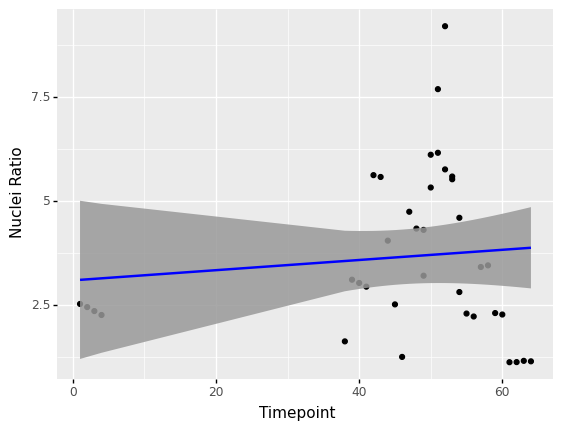

<ggplot: (115524026792)>

In [124]:
ggplot(cut_wt, aes('Timepoint', 'Nuclei Ratio')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

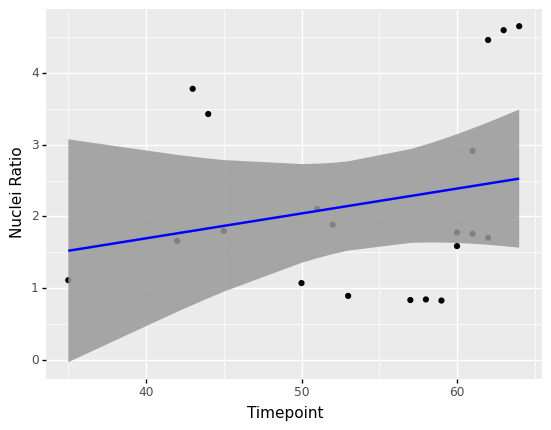

<ggplot: (115523855045)>

In [125]:
ggplot(cut_c4, aes('Timepoint', 'Nuclei Ratio')) +\
    geom_point() +\
    geom_smooth(method = "lm", color = 'b', alpha = 0.85)

In [39]:
df = pd.DataFrame(columns=['dfd', 'de'])
df = df.append({'dfd':2, 'de':7}, ignore_index = True).astype('int32')

C:\Users\Student\AppData\Local\Temp\ipykernel_8304\2582642266.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [40]:
df.dtypes

dfd    int32
de     int32
dtype: object

In [41]:
df

,dfd,de
0,2,7
